# Training DNN With GPU

In [17]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'         ## matplotlib figure에 흰색 배경나오도록

In [3]:
dataset = MNIST(root='./data', download=True, transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



image shape:  torch.Size([1, 28, 28])
Label:  5


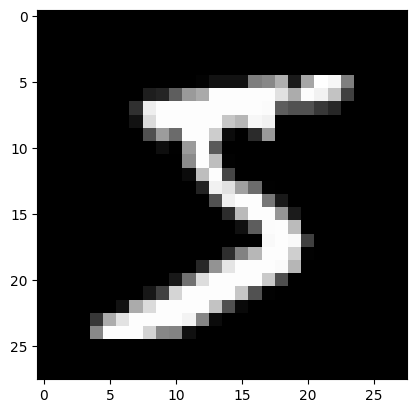

In [4]:
image, label = dataset[0]
print('image shape: ', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label: ', label)

In [5]:
val_size = 10000
train_size = len(dataset) -val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [8]:
batch_size = 128

# num_workers : data를 로딩할 때 사용할 서브 프로세스의 수, 0이면 메인 프로세스에서 진행, 여러 서브 프로세스를 이용해 병렬로 진행가능
# pin_memory : GPU로 데이터 전송이 더 빠르게 하는 방법, 추가적인 메모리 필요
train_loder = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loder = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

image shape:  torch.Size([128, 1, 28, 28])


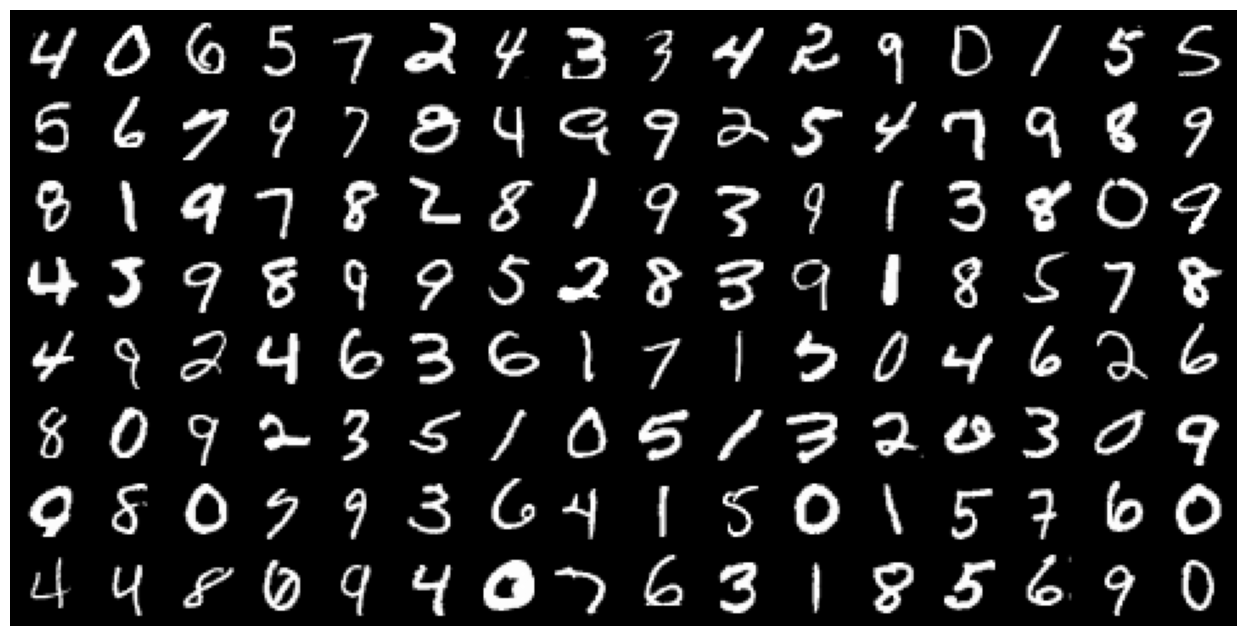

In [9]:
for images, _ in train_loder:
    print('image shape: ', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
    break

In [10]:
# 1x28x28 -> 784
for images, labels in train_loder:
    print('images.shaape: ', images.shape)
    inputs = images.reshape(-1, 784)
    print('input_shape: ', inputs.shape)
    break

images.shaape:  torch.Size([128, 1, 28, 28])
input_shape:  torch.Size([128, 784])


# Model

In [19]:
class DNN(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.layer1 = nn.Linear(in_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        # Flatten tensor
        xb = xb.view(xb.size(0), -1)

        out = self.layer1(xb)
        out = F.relu(out)
        out = self.layer2(out)
        
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def val_step(self, batch):
        images, labbels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss' : loss, 'val_acc' : acc}
    
    def val_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack[batch_accs].mean()
        return {'val_loss' : epoch_loss.item(), 'val_acc' : epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [20]:
def accuracy(out, labels):
    _, preds = torch.max(out, dim=1)
    return torch.Tensor(torch.sum(preds == labels).item() / len(preds))

In [21]:
input_size = 784
hidden_size = 32
num_classes = 10

model = DNN(input_size, hidden_size, out_size=num_classes)

In [22]:
for images, labels in train_loder:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss: ', loss.item())
    break

Loss:  2.3096718788146973


# Using GPU

In [23]:
torch.cuda.is_available()

False

In [24]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [25]:
def to_device(data, device):
    # tensor(data)를 고른 device로 이동
    if isinstance(data, (list, tuple)):                     ##data가 list나 tuple로 구성되어있을 때, 재귀적으로 호출
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [27]:
device = get_default_device()

for images, labels in train_loder:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cpu


In [30]:
# data batch 하나씩 이동
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)             # 지정된 장치로 이동시킨 후 yield를 통해 반환

    def __len__(self):
        return len(self.dl)

In [31]:
train_loader = DeviceDataLoader(train_loder, device)
val_loader = DeviceDataLoader(val_loder, device)

In [32]:
def evaluate(model, val_loader):
    outputs = [model.val_step(batch) for batch in val_loder]
    return model.val_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    opt = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history